# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [ ]:
!pip install palmerpenguins
from palmerpenguins import penguins
penguins = penguins.load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [ ]:
penguins_dummy.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year,species_Adelie,species_Chinstrap,species_Gentoo,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,39.1,18.7,181.0,3750.0,2007,True,False,False,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,2007,True,False,False,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,2007,True,False,False,False,False,True,True,False
3,NaN,NaN,NaN,NaN,2007,True,False,False,False,False,True,False,False
4,36.7,19.3,193.0,3450.0,2007,True,False,False,False,False,True,True,False


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

y = penguins["bill_depth_mm"]
X = penguins.drop("bill_depth_mm", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# target and features
y = penguins["bill_depth_mm"]
X = penguins.drop(columns=["bill_depth_mm"])

# drop rows with missing data (simple approach)
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=["bill_depth_mm"])
y = data["bill_depth_mm"]

# identify numeric vs categorical
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# column transformer (scale numeric, one-hot encode categorical)
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
    ]
)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# use the same subset of features you decided was best before
best_feature_names = ["body_mass_g","species"]   # e.g. ["bill_length_mm","flipper_length_mm","body_mass_g","species"]


preprocess_best = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in best_feature_names if c in num_features]),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"),
         [c for c in best_feature_names if c in cat_features]),
    ]
)

lin_pipeline = Pipeline([
    ("preprocess", preprocess_best),
    ("model", LinearRegression())
])

lr_fitted = lin_pipeline.fit(X_train_best, y_train)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", KNeighborsRegressor())
])

param_grid = {
    "model__n_neighbors": [1, 3, 5, 7, 9, 11, 15, 20, 25, 30]
}

# 5-fold CV to pick best K (on *training* data only)
gscv_knn = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5
)

gscv_knn.fit(X_train, y_train)

best_k = gscv_knn.best_params_["model__n_neighbors"]
print("Best K:", best_k)

Best K: 5


In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_pipeline = Pipeline([
    ("preprocess", preprocess),
    ("model", DecisionTreeRegressor(max_depth=5, random_state=123))
])


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

models = {
    "Linear (best)": lin_pipeline,
    "kNN K=3": knn3_pipeline,
    "kNN K=15": knn15_pipeline,
    "Decision Tree": tree_pipeline,
}

train_errors = {}
test_errors = {}

for name, pipe in models.items():
    if name == "Linear (best)":
        pipe.fit(X_train_best, y_train)
        y_train_pred = pipe.predict(X_train_best)
        y_test_pred  = pipe.predict(X_test_best)
    else:
        pipe.fit(X_train, y_train)
        y_train_pred = pipe.predict(X_train)
        y_test_pred  = pipe.predict(X_test)

    train_errors[name] = mean_squared_error(y_train, y_train_pred)
    test_errors[name]  = mean_squared_error(y_test,  y_test_pred)

train_errors, test_errors


({'Linear (best)': 0.6929699779474635,
  'kNN K=3': 0.3343483709273182,
  'kNN K=15': 0.5440648287385131,
  'Decision Tree': 0.32895339031841575},
 {'Linear (best)': 1.041717289216343,
  'kNN K=3': 0.9381426202321722,
  'kNN K=15': 0.9626262023217251,
  'Decision Tree': 0.9641964938686223})

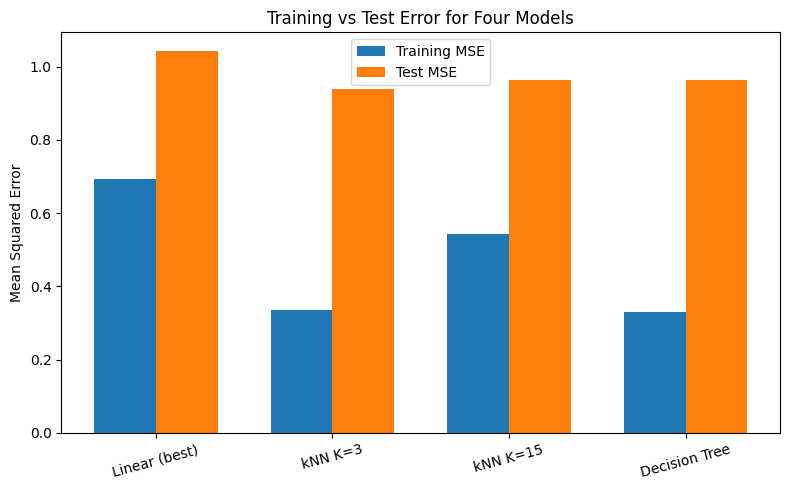

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

model_names = list(models.keys())
x = np.arange(len(model_names))
width = 0.35

train_vals = [train_errors[m] for m in model_names]
test_vals  = [test_errors[m]  for m in model_names]

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_vals, width, label="Training MSE")
plt.bar(x + width/2, test_vals,  width, label="Test MSE")

plt.xticks(x, model_names, rotation=15)
plt.ylabel("Mean Squared Error")
plt.title("Training vs Test Error for Four Models")
plt.legend()
plt.tight_layout()
plt.show()
